In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [6]:
data_dir = '/content/drive/MyDrive/dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)
data_dir

,filepaths,labels
0,/content/drive/MyDrive/dataset/21096911_Nguyen...,21096911_NguyenNhatTung
1,/content/drive/MyDrive/dataset/21096911_Nguyen...,21096911_NguyenNhatTung
2,/content/drive/MyDrive/dataset/21096911_Nguyen...,21096911_NguyenNhatTung
3,/content/drive/MyDrive/dataset/21096911_Nguyen...,21096911_NguyenNhatTung
4,/content/drive/MyDrive/dataset/21096911_Nguyen...,21096911_NguyenNhatTung
...,...,...
2865,/content/drive/MyDrive/dataset/21105351_TongTh...,21105351_TongThanhLoc
2866,/content/drive/MyDrive/dataset/21105351_TongTh...,21105351_TongThanhLoc
2867,/content/drive/MyDrive/dataset/21105351_TongTh...,21105351_TongThanhLoc
2868,/content/drive/MyDrive/dataset/21105351_TongTh...,21105351_TongThanhLoc


In [7]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [8]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=10,        # Randomly rotate images within the range [-30, 30] degrees
    width_shift_range=0.1,    # Shift images horizontally within [-20%, 20%]
    height_shift_range=0.1,   # Shift images vertically within [-20%, 20%]
    shear_range=0.2,          # Apply shear transformations
    zoom_range=0.2,           # Randomly zoom in or out
    fill_mode="nearest"       # Fill in missing pixels using the nearest method
)

ts_gen = ImageDataGenerator()  # No augmentation for the test set

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2296 validated image filenames belonging to 6 classes.
Found 344 validated image filenames belonging to 6 classes.
Found 230 validated image filenames belonging to 6 classes.


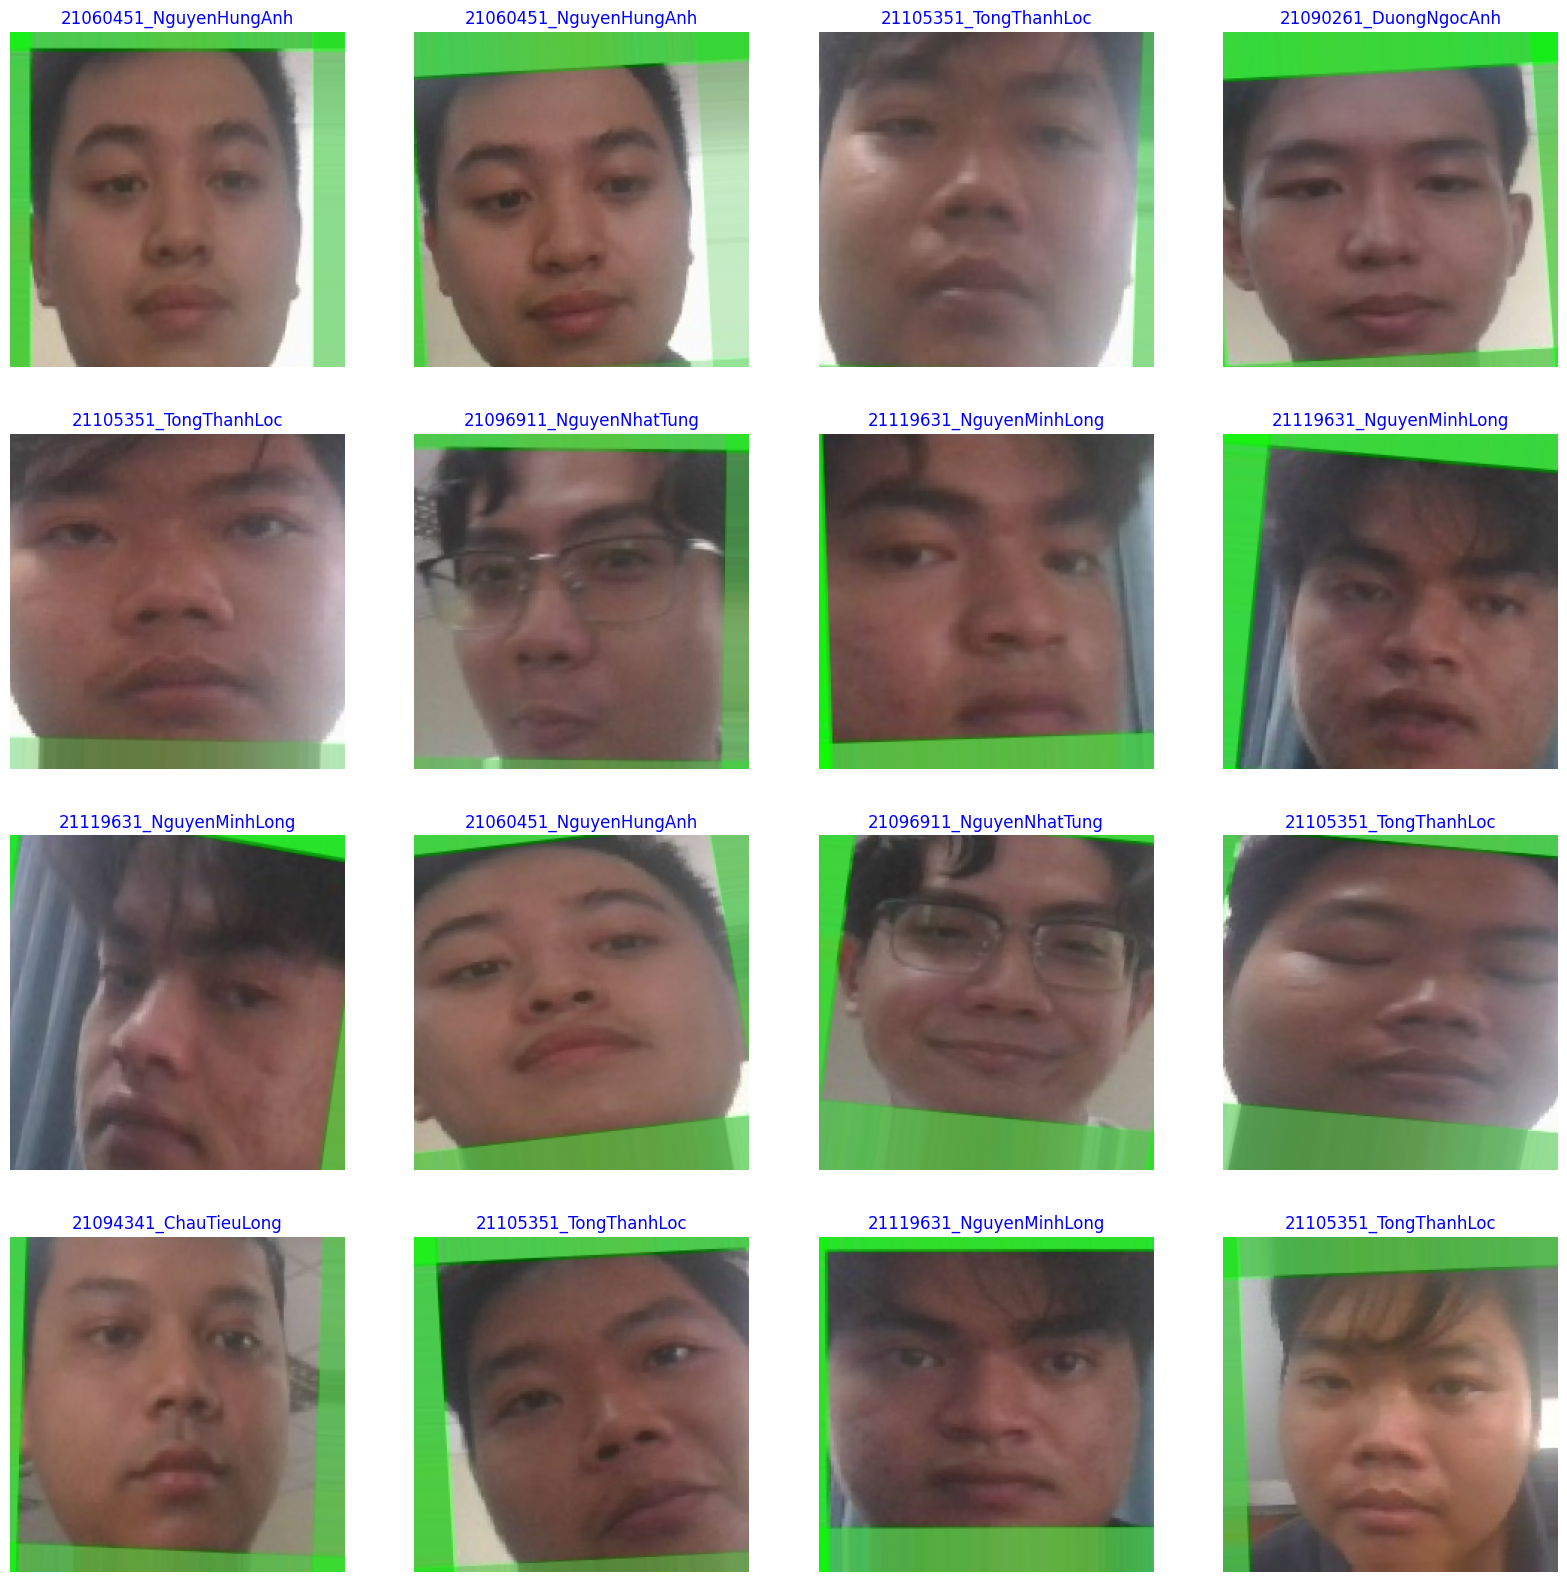

In [13]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [14]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,384,169 (16.72 MB)

 Trainable params: 4,339,586 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [15]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)


Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 150s 577ms/step - accuracy: 0.5400 - loss: 14.3717 - val_accuracy: 0.1424 - val_loss: 7.3727
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 267ms/step - accuracy: 0.2923 - loss: 7.1254 - val_accuracy: 0.2355 - val_loss: 6.9920
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.2617 - loss: 6.2038 - val_accuracy: 0.2791 - val_loss: 5.6188
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 266ms/step - accuracy: 0.2658 - loss: 5.4053 - val_accuracy: 0.2500 - val_loss: 4.8793
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 270ms/step - accuracy: 0.2769 - loss: 4.6684 - val_accuracy: 0.3081 - val_loss: 4.4060
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 260ms/step - accuracy: 0.2710 - loss: 4.0916 - val_accuracy: 0.2907 - val_loss: 3.7008
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.2822 - loss: 3.5761 - val_accuracy: 0.3227 - val_loss: 3.2477
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.3133 - loss:

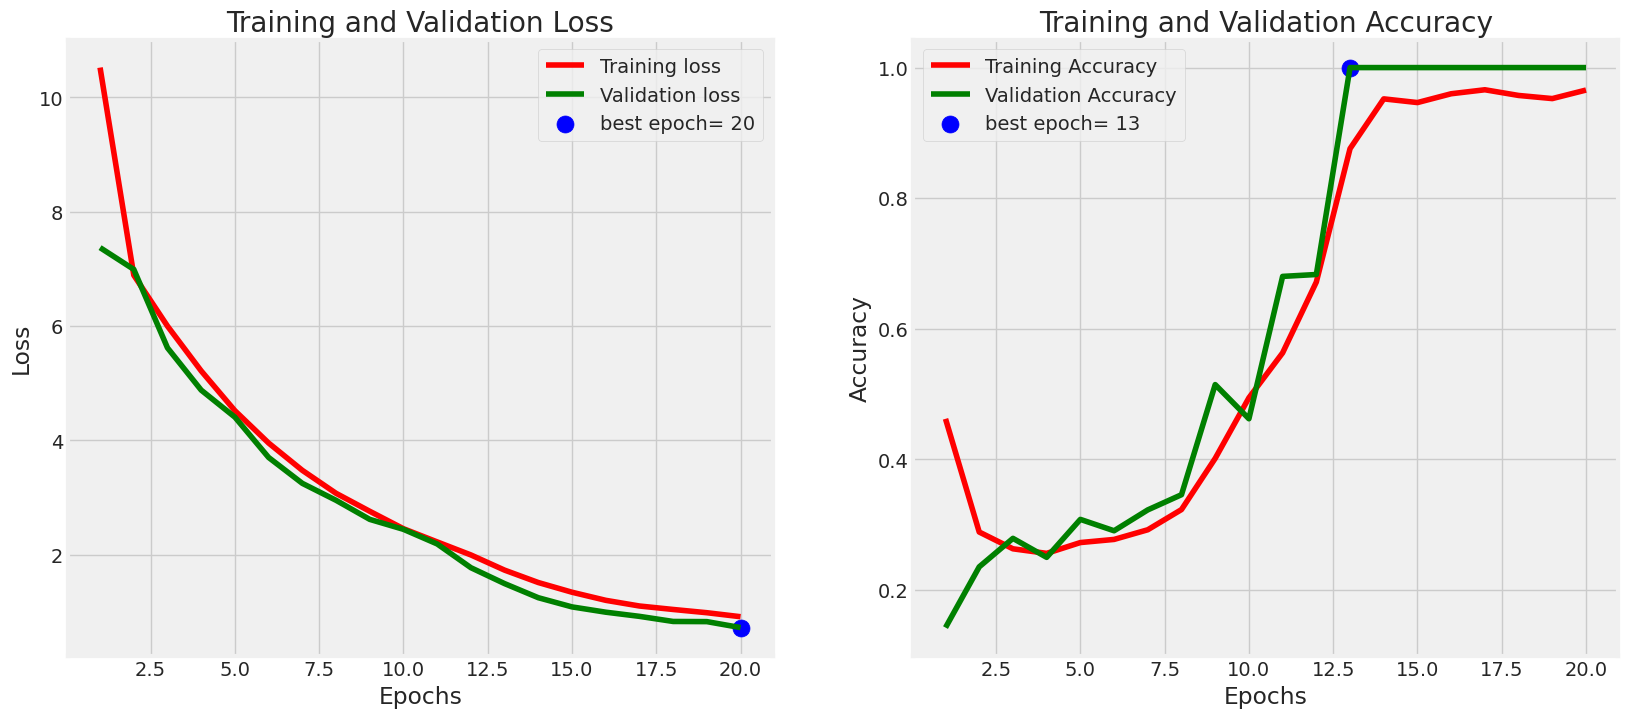

In [16]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [17]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 1.0000 - loss: 0.7306
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.7299
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 1.0000 - loss: 0.7299
Train Loss:  0.7416661381721497
Train Accuracy:  1.0
--------------------
Validation Loss:  0.7306773066520691
Validation Accuracy:  1.0
--------------------
Test Loss:  0.7300047874450684
Test Accuracy:  1.0


In [22]:
#Save the model
model.save('/content/drive/MyDrive/efficientNetB0.keras')

In [4]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/efficientNetB0.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [24]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


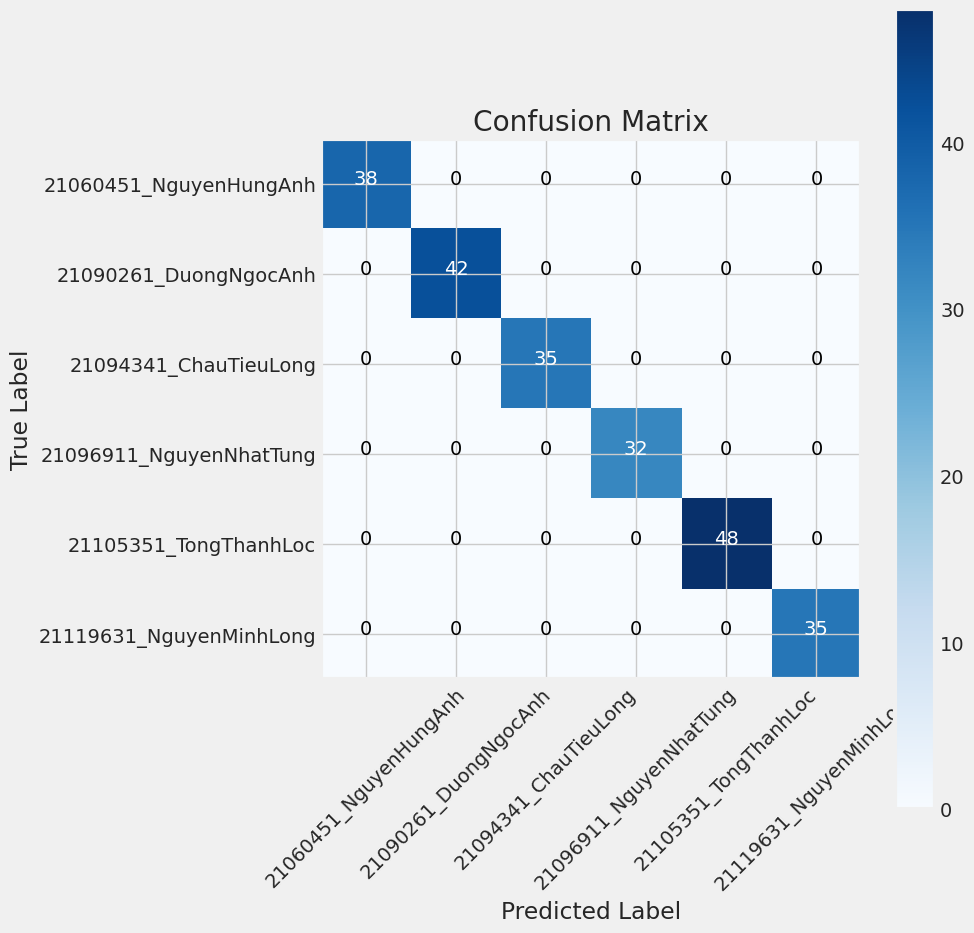

In [25]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Đường dẫn đến ảnh
image_path = 'tải xuống.jpg'
image = Image.open(image_path)

# Tiền xử lý ảnh
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Thêm batch dimension

# Dự đoán
predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Lấy nhãn dự đoán
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
predicted_label = classes[np.argmax(score)]
confidence = 100 * np.max(score)

# Hiển thị hình ảnh và nhãn dự đoán
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=12, color='blue')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


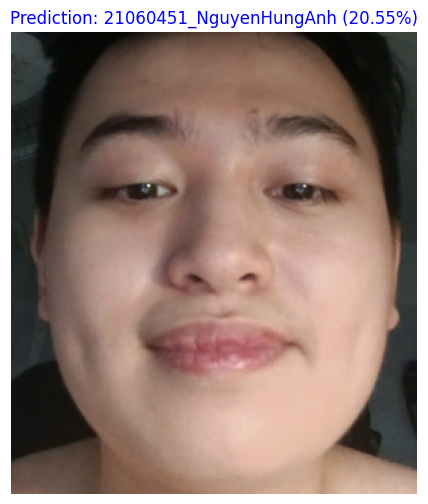

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Đường dẫn đến ảnh
image_path = '/content/drive/MyDrive/Screenshot 2025-04-04 101743.png'
image = Image.open(image_path).convert('RGB')  # <- thêm .convert('RGB')

# Tiền xử lý ảnh
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Thêm batch dimension

# Dự đoán
predictions = loaded_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Lấy nhãn dự đoán
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
predicted_label = classes[np.argmax(score)]
confidence = 100 * np.max(score)

# Hiển thị hình ảnh và nhãn dự đoán
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=12, color='blue')
plt.show()


In [12]:
score

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([0.2055306 , 0.16050237, 0.15895088, 0.15865844, 0.15974793,
       0.15660977], dtype=float32)>